In [45]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn import svm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.neighbors import KNeighborsClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
%matplotlib inline

In [5]:
business = pd.read_csv("/home/kai/yelp_dataset/business.csv")
review_all = pd.read_csv("/home/kai/yelp_dataset/review.csv")

In [6]:
a = business[business['categories'].str.contains('Restaurant') == True]
rev = review_all[review_all.business_id.isin(a['business_id']) == True]

In [7]:
rev_samp = rev.sample(n = 350000, random_state = 42)
train = rev_samp[0:280000]
test = rev_samp[280000:]

In [8]:
train.shape, test.shape

((280000, 9), (70000, 9))

,text,stars
2760442,Second time here.... first time had the pulled...,5
3014452,Great place. Like their sauce and lunch specia...,5
2876979,So goooooooood and so simple! I love their pel...,5
469097,We stopped in for a late lunch on a Tuesday af...,3
4971248,A great option to try hakka chinese since its ...,4


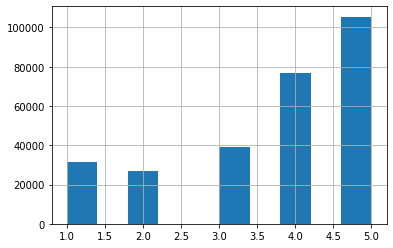

In [9]:
train = train[['text', 'stars']]
train['stars'].hist();train.head()

In [10]:
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
2760442,Second time here.... first time had the pulled...,0,0,0,0,1
3014452,Great place. Like their sauce and lunch specia...,0,0,0,0,1
2876979,So goooooooood and so simple! I love their pel...,0,0,0,0,1
469097,We stopped in for a late lunch on a Tuesday af...,0,0,1,0,0
4971248,A great option to try hakka chinese since its ...,0,0,0,1,0


In [11]:
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns = ['stars'])
train.shape, test.shape

((280000, 6), (70000, 6))

In [12]:
train_samp = train.sample(frac = .1, random_state = 42)
test_samp = test.sample(frac = .1, random_state = 42)
train_samp.shape, test_samp.shape

((28000, 6), (7000, 6))

In [13]:
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

In [14]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [15]:
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [16]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train_samp[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]

CV score for class stars_1 is 0.9282499819604656
CV score for class stars_2 is 0.90339283521352
CV score for class stars_3 is 0.8591786654537303
CV score for class stars_4 is 0.7321071676830603
CV score for class stars_5 is 0.8044644727087923


In [17]:
train['text'][4971248]

'A great option to try hakka chinese since its halal! We had cantonese chow mein, chicken 88 and spicy fish with vegetable stir fry rice and that was all enough for four people to eat! Beware, their portion sizes are huge and that will be your only complaint! For those that like mild spices though, you will have to ask them to keep it mild!'

In [18]:
t = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       771
           1       0.43      0.15      0.23       687
           2       0.49      0.31      0.38      1020
           3       0.47      0.46      0.47      1906
           4       0.67      0.85      0.75      2616

    accuracy                           0.59      7000
   macro avg       0.54      0.50      0.50      7000
weighted avg       0.56      0.59      0.56      7000



In [19]:
embed_size = 200 
# max number of unique words 
max_features = 20000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = '/home/kai/yelp_dataset/glove.twitter.27B.200d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [20]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
# Splitting off my y variable
y = train_samp[class_names].values

In [21]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [22]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [23]:
len(missed)

2147

In [24]:
missed[0:10]

["it's", "don't", "i'm", "i've", "didn't", '5', '2', '3', "wasn't", '4']

In [25]:
missed[1000:1010]

["lobby's",
 "capo's",
 "'fast",
 'gratuities',
 "owners'",
 'brasseurs',
 'mittagszeit',
 "soup'",
 "pauly's",
 "flo's"]

In [26]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
print (model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     4000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 80)      77120       spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [27]:
model.fit(x_train, y, batch_size = 512, epochs = 20, validation_split = .1, callbacks=[earlystop, checkpoint])

Epoch 1/20
50/50 [==============================] - 52s 959ms/step - loss: 0.1582 - accuracy: 0.3643 - val_loss: 0.1461 - val_accuracy: 0.3843
Epoch 2/20
50/50 [==============================] - 46s 921ms/step - loss: 0.1363 - accuracy: 0.4270 - val_loss: 0.1239 - val_accuracy: 0.5032
Epoch 3/20
50/50 [==============================] - 45s 898ms/step - loss: 0.1206 - accuracy: 0.5137 - val_loss: 0.1128 - val_accuracy: 0.5568
Epoch 4/20
50/50 [==============================] - 47s 935ms/step - loss: 0.1117 - accuracy: 0.5562 - val_loss: 0.1063 - val_accuracy: 0.5882
Epoch 5/20
50/50 [==============================] - 47s 931ms/step - loss: 0.1062 - accuracy: 0.5862 - val_loss: 0.1070 - val_accuracy: 0.5732
Epoch 6/20
50/50 [==============================] - 46s 920ms/step - loss: 0.1022 - accuracy: 0.6037 - val_loss: 0.1022 - val_accuracy: 0.5968
Epoch 7/20
50/50 [==============================] - 53s 1s/step - loss: 0.0998 - accuracy: 0.6145 - val_loss: 0.1018 - val_accuracy: 0.6050
Ep

In [28]:
y_test = model.predict([x_test], batch_size=1024, verbose = 1)

7/7 [==============================] - 6s 651ms/step


In [29]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)

7/7 [==============================] - 5s 661ms/step - loss: 0.1014 - accuracy: 0.6160


[0.10136958211660385, 0.6159999966621399]

In [30]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       771
           1       0.43      0.39      0.41       687
           2       0.50      0.43      0.46      1020
           3       0.52      0.54      0.53      1906
           4       0.74      0.78      0.76      2616

    accuracy                           0.62      7000
   macro avg       0.58      0.57      0.57      7000
weighted avg       0.61      0.62      0.61      7000



In [31]:
model.save('yelp_nn_model.h5')

In [32]:
start = time.time()
history = model.fit(x_train, y, validation_data= (x_test, y_test), 
          batch_size = 32,callbacks=[earlystop,checkpoint],
          verbose=0,epochs=100)
print("Time to train:", time.time() - start)
model.load_weights("yelp_lstm_gru_weights.hdf5")

Time to train: 553.5746953487396


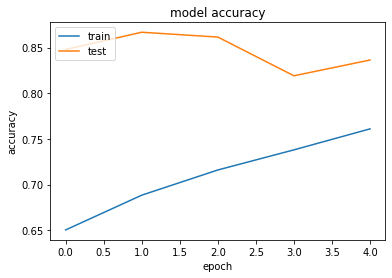

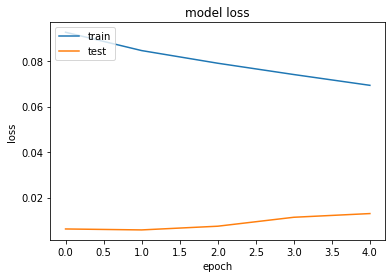

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
true_classes = np.argmax(y_test,axis=1)
total_activation = ["relu", "sigmoid","tanh"]
optimizers = ["adam","sgd"]

result = {}

for i in total_activation:
    for j in optimizers:
        model = Sequential()
        
        model.add(Dense(4,input_dim = inp.shape[1], activation = i))
        model.add(Dense(8, activation=i)) # Hidden 2
#         model.add(Dense(8, activation=i)) # Hidden 3
        model.add(Dense(outp.shape[1], activation='softmax')) # Output
        
        model.compile(loss='categorical_crossentropy', optimizer=j, metrics = ['accuracy'])
        
        monitor = EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience = 4, verbose=0, mode = 'auto')
        
        checkpoint = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_loss', save_best_only=True)
        start = time.time()
        
        history = model.fit(x_train, y, validation_data= (x_test, y_test), 
          batch_size = 32,callbacks=[monitor,checkpoint],
          verbose=0,epochs=100)
        pred = model.predict(x_test)
        predict_classes = np.argmax(pred,axis=1)
        
#         print("Predictions for model:")
#         for k in range(5):
#             print(lab_enc.inverse_transform(true_classes[k]),"\t\t",lab_enc.inverse_transform(predict_classes[k]))
        accuracy = accuracy_score(true_classes,predict_classes)
        data = {
            "Accuracy" : accuracy*100,
            "Activation" : i,
            "Optimizer" : j,
            "Train time(sec):" : (time.time() - start)
        }
        result[i+ ' '+j] = data
result_of_project_2 = pd.DataFrame(result)

In [35]:
result_of_project_2

,relu adam,relu sgd,sigmoid adam,sigmoid sgd,tanh adam,tanh sgd
Accuracy,39.2286,39.2286,42.1286,39.2286,42.8286,40.3429
Activation,relu,relu,sigmoid,sigmoid,tanh,tanh
Optimizer,adam,sgd,adam,sgd,adam,sgd
Train time(sec):,11.1644,3.4384,6.58684,10.5505,9.8709,9.42492
